In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

In [4]:
from Tool_Functions import *

In [5]:
(beta1, beta2_values, M, n_train, n_test, seed, epsilon,
           x, x_train, x_test, epsilon_train, epsilon_test,
           liste_y, liste_y_train, liste_y_test)  = data_gen_process()

In [6]:
coefs_A, coefs_B, erreurs_A, erreurs_B = models_fit()
pa = erreurs_A[-1]
pb = erreurs_B[-1]
diff = pa - pb

In [7]:
def standard_error():
   
   mean_A = np.mean(pa)
   mean_B = np.mean(pb)
   mean_diff = np.mean(diff)

   se_A = np.std(pa)/(n_test**0.5)
   se_B = np.std(pb)/(n_test**0.5)
   se_diff = np.std(diff)/(n_test**0.5)

   return mean_A, mean_B, mean_diff, se_A, se_B, se_diff

mean_A, mean_B, mean_diff, se_A, se_B, se_diff = standard_error()

def classic_bootstrapping():

   B = 250
   bootstrap_indices = np.random.choice(n_test, size=(B, n_test), replace=True)
   bootstrap = []

   for indices in bootstrap_indices:
      boot_mean = np.mean(pa[indices])
      bootstrap.append(boot_mean)

   mean_A_boot = np.mean(bootstrap)
   se_boot_A = np.std(bootstrap)

   bootstrap = []

   for indices in bootstrap_indices:
      boot_mean = np.mean(pb[indices])
      bootstrap.append(boot_mean)

   mean_B_boot = np.mean(bootstrap)
   se_boot_B = np.std(bootstrap)

   bootstrap = []

   for indices in bootstrap_indices:
      boot_mean = np.mean(diff[indices])
      bootstrap.append(boot_mean)

   mean_diff_boot = np.mean(bootstrap)
   se_boot_diff = np.std(bootstrap)


   return mean_A_boot, mean_B_boot, mean_diff_boot, se_boot_A, se_boot_B, se_boot_diff

mean_A_boot, mean_B_boot, mean_diff_boot, se_boot_A, se_boot_B, se_boot_diff = classic_bootstrapping()

In [8]:
# Check for normality assumption, used to construct confidence intervals

def check_normality():
       
   B = 250
   bootstrap_indices = np.random.choice(n_test, size=(B, n_test), replace=True)
   bootstrap = []

   for indices in bootstrap_indices:
      boot_mean = np.mean(pa[indices])
      bootstrap.append(boot_mean)
    
   plt.figure()
   plt.title("Distribution des erreurs moyennes bootstrappées de A")
   plt.hist(bootstrap, bins=30, edgecolor = "black", alpha=0.7)
   plt.axvline(np.mean(pa), color = "red", linewidth = 3)
   plt.xlabel("Valeurs")
   plt.ylabel("Fréquence")
   plt.show()


   bootstrap = []
   for indices in bootstrap_indices:
      boot_mean = np.mean(pb[indices])
      bootstrap.append(boot_mean)
    
   plt.figure()
   plt.title("Distribution des erreurs moyennes bootstrappées de B")
   plt.hist(bootstrap, bins=30, edgecolor = "black", alpha=0.7)
   plt.axvline(np.mean(pb), color = "red", linewidth = 3)
   plt.xlabel("Valeurs")
   plt.ylabel("Fréquence")
   plt.show()

   bootstrap = []
   for indices in bootstrap_indices:
      boot_mean = np.mean(diff[indices])
      bootstrap.append(boot_mean)
    
   plt.figure()
   plt.title("Distribution des erreurs moyennes bootstrappées de la différence")
   plt.hist(bootstrap, bins=30, edgecolor = "black", alpha=0.7)
   plt.axvline(np.mean(diff), color = "red", linewidth = 3)
   plt.xlabel("Valeurs")
   plt.ylabel("Fréquence")
   plt.show()

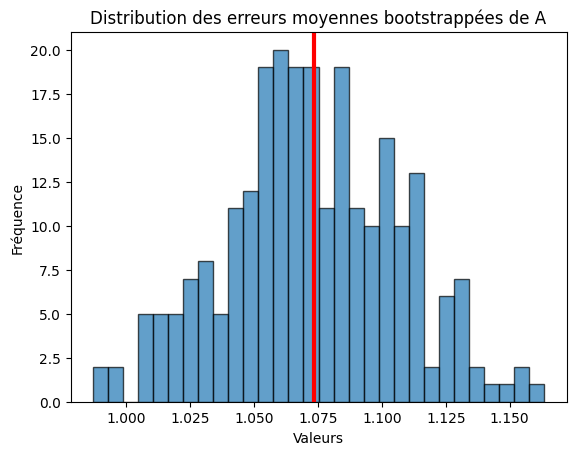

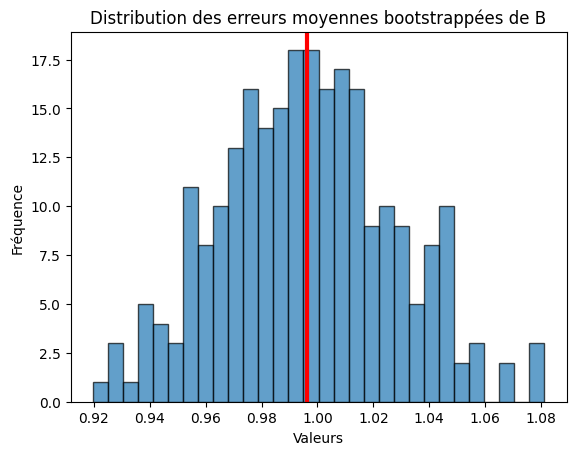

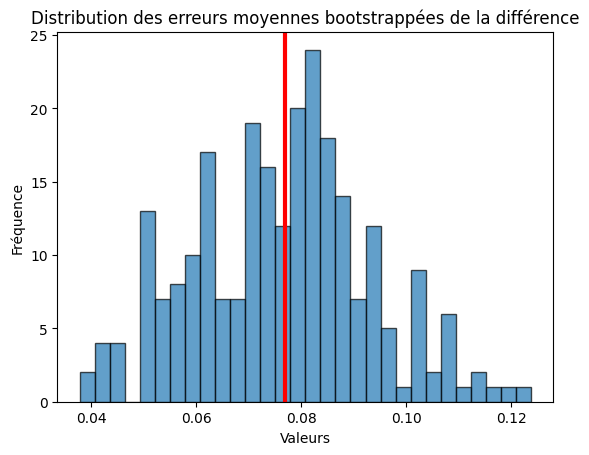

In [9]:
check_normality()

In [10]:
def jackknife():

    jackknife = []
    for i in range(len(pa)):
        partial_mean = np.mean(np.delete(pa,i))
        jackknife.append(partial_mean)

    deviation = ((n_test-1)/n_test)*sum((jackknife-np.mean(pa))**2)
    se_jack_A = np.sqrt(deviation)

    jackknife = []
    for i in range(len(pb)):
        partial_mean = np.mean(np.delete(pb,i))
        jackknife.append(partial_mean)

    deviation = ((n_test-1)/n_test)*sum((jackknife-np.mean(pb))**2)
    se_jack_B = np.sqrt(deviation)

    jackknife = []
    for i in range(len(diff)):
        partial_mean = np.mean(np.delete(diff,i))
        jackknife.append(partial_mean)

    deviation = ((n_test-1)/n_test)*sum((jackknife-np.mean(diff))**2)
    se_jack_diff = np.sqrt(deviation)

    return se_jack_A, se_jack_B, se_jack_diff

In [11]:
def bca_boot(alpha=0.05):
    
    B = 250
    bootstrap_indices = np.random.choice(n_test, size=(B, n_test), replace=True)
    sample_means = []

    for indices in bootstrap_indices:
      
      boot_mean = np.mean(pa[indices])
      sample_means.append(boot_mean)
    
    original_mean = np.mean(pa)

    # Acceleration
    jackknife_samples = np.array([np.mean(np.delete(pa, i)) for i in range(len(pa))])
    jackknife_mean = np.mean(jackknife_samples)
    a = np.sum((jackknife_mean - jackknife_samples) ** 3) / (6 * np.sum((jackknife_mean - jackknife_samples) ** 2) ** 1.5)

    # Bias correction
    z0 = stats.norm.ppf(np.mean(sample_means < original_mean))

    # Confidence intervals
    lower_percentile = 100 * stats.norm.cdf(2 * z0 + stats.norm.ppf(alpha / 2))
    upper_percentile = 100 * stats.norm.cdf(2 * z0 + stats.norm.ppf(1 - alpha / 2))
    conf_interval = np.percentile(sample_means, [lower_percentile, upper_percentile])

    return original_mean, conf_interval

original_mean, conf_interval = bca_boot()
print("Original Mean:", original_mean)
print("Confidence Interval:", conf_interval)


Original Mean: 1.073222258507699
Confidence Interval: [1.01314381 1.11936069]


# Comparaison des erreurs standards

In [12]:
mean_A, mean_B, mean_diff, se_A, se_B, se_diff = standard_error()
mean_A_boot, mean_B_boot, mean_diff_boot, se_boot_A, se_boot_B, se_boot_diff = classic_bootstrapping()
se_jack_A, se_jack_B, se_jack_diff = jackknife()

In [13]:
print("Erreur standard A:", se_A)
print("Erreur standard A jackknife:", se_jack_A)
print("Erreur standard A bootstrap:", se_boot_A)
print("Erreur standard B:", se_B)
print("Erreur standard B jackknife:", se_jack_B)
print("Erreur standard B bootstrap:", se_boot_B)
print("Erreur standard diff:", se_diff)
print("Erreur standard diff jackknife:", se_jack_diff)
print("Erreur standard diff bootstrap:", se_boot_diff)


Erreur standard A: 0.03268890191811695
Erreur standard A jackknife: 0.03269707720945842
Erreur standard A bootstrap: 0.030090747468209937
Erreur standard B: 0.030986805115987327
Erreur standard B jackknife: 0.030994554723490185
Erreur standard B bootstrap: 0.028598296626298262
Erreur standard diff: 0.015191405606780981
Erreur standard diff jackknife: 0.0151952048829706
Erreur standard diff bootstrap: 0.01489916762193769
